
<a id='odu'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Job Search III: Search with Learning

## Contents

- [Job Search III: Search with Learning](#Job-Search-III:-Search-with-Learning)  
  - [Overview](#Overview)  
  - [Model](#Model)  
  - [Take 1: Solution by VFI](#Take-1:-Solution-by-VFI)  
  - [Take 2: A More Efficient Method](#Take-2:-A-More-Efficient-Method)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

In this lecture we consider an extension of the [previously studied](mccall_model.html) job search model of McCall [[McC70]](../zreferences.html#mccall1970).

In the McCall model, an unemployed worker decides when to accept a permanent position at a specified wage, given

- his or her discount rate  
- the level of unemployment compensation  
- the distribution from which wage offers are drawn  


In the version considered below, the wage distribution is unknown and must be learned.

- The following is based on the presentation in [[LS18]](../zreferences.html#ljungqvist2012), section 6.6.  

### Model features

- Infinite horizon dynamic programming with two states and one binary control.  
- Bayesian updating to learn the unknown distribution.  

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.4.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.4.0", instantiate = true) # uncomment to force package installation

## Model


<a id='index-0'></a>
Let’s first review the basic McCall model [[McC70]](../zreferences.html#mccall1970) and then add the variation we want to consider.

### The Basic McCall Model


<a id='index-1'></a>
Recall that, [in the baseline model](mccall_model.html), an unemployed worker is presented in each period with a
permanent job offer at wage $ W_t $.

At time $ t $, our worker either

1. accepts the offer and works permanently at constant wage $ W_t $  
1. rejects the offer, receives unemployment compensation $ c $ and reconsiders next period  


The wage sequence $ \{W_t\} $ is iid and generated from known density $ h $.

The worker aims to maximize the expected discounted sum of earnings $ \mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t $
The function $ V $ satisfies the recursion


<a id='equation-odu-odu-pv'></a>
$$
V(w)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int V(w')h(w') dw'
\right\} \tag{1}
$$

The optimal policy has the form $ \mathbf{1}\{w \geq \bar w\} $, where
$ \bar w $ is a constant depending called the *reservation wage*.

### Offer Distribution Unknown

Now let’s extend the model by considering the variation presented in [[LS18]](../zreferences.html#ljungqvist2012), section 6.6.

The model is as above, apart from the fact that

- the density $ h $ is unknown  
- the worker learns about $ h $ by starting with a prior and updating based on wage offers that he/she observes  


The worker knows there are two possible distributions $ F $ and $ G $ — with densities $ f $ and $ g $.

At the start of time, “nature” selects $ h $ to be either $ f $ or
$ g $ — the wage distribution from which the entire sequence $ \{W_t\} $ will be drawn.

This choice is not observed by the worker, who puts prior probability $ \pi_0 $ on $ f $ being chosen.

Update rule: worker’s time $ t $ estimate of the distribution is $ \pi_t f + (1 - \pi_t) g $, where $ \pi_t $ updates via


<a id='equation-odu-pi-rec'></a>
$$
\pi_{t+1}
= \frac{\pi_t f(w_{t+1})}{\pi_t f(w_{t+1}) + (1 - \pi_t) g(w_{t+1})} \tag{2}
$$

This last expression follows from Bayes’ rule, which tells us that

$$
\mathbb{P}\{h = f \,|\, W = w\}
= \frac{\mathbb{P}\{W = w \,|\, h = f\}\mathbb{P}\{h = f\}}
{\mathbb{P}\{W = w\}}
\quad \text{and} \quad
\mathbb{P}\{W = w\} = \sum_{\psi \in \{f, g\}} \mathbb{P}\{W = w \,|\, h = \psi\} \mathbb{P}\{h = \psi\}
$$

The fact that [(2)](#equation-odu-pi-rec) is recursive allows us to progress to a recursive solution method.

Letting

$$
h_{\pi}(w) := \pi f(w) + (1 - \pi) g(w)
\quad \text{and} \quad
q(w, \pi) := \frac{\pi f(w)}{\pi f(w) + (1 - \pi) g(w)}
$$

we can express the value function for the unemployed worker recursively as
follows


<a id='equation-odu-mvf'></a>
$$
V(w, \pi)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int V(w', \pi') \, h_{\pi}(w') \, dw'
\right\}
\quad \text{where} \quad
\pi' = q(w', \pi) \tag{3}
$$

Notice that the current guess $ \pi $ is a state variable, since it affects the worker’s perception of probabilities for future rewards.

### Parameterization

Following  section 6.6 of [[LS18]](../zreferences.html#ljungqvist2012), our baseline parameterization will be

- $ f $ is $ \operatorname{Beta}(1, 1) $ scaled (i.e., draws are multiplied by) some factor $ w_m $  
- $ g $ is $ \operatorname{Beta}(3, 1.2) $ scaled (i.e., draws are multiplied by) the same factor $ w_m $  
- $ \beta = 0.95 $ and $ c = 0.6 $  


With $ w_m = 2 $, the densities $ f $ and $ g $ have the following shape

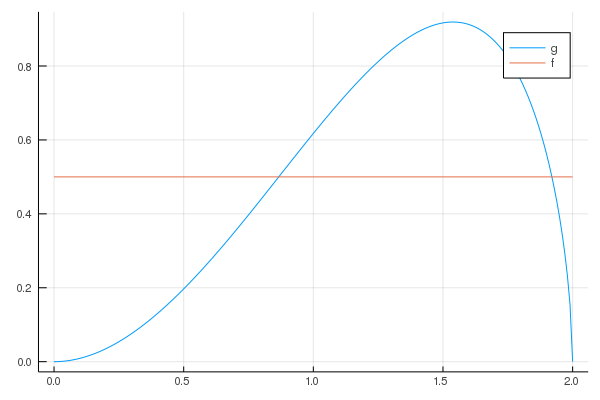

In [2]:
using LinearAlgebra, Statistics
using Distributions, Plots, QuantEcon, Interpolations, Parameters

gr(fmt=:png);

w_max = 2
x = range(0,  w_max, length = 200)

G = Beta(3, 1.6)
F = Beta(1, 1)
plot(x, pdf.(G, x/w_max)/w_max, label="g")
plot!(x, pdf.(F, x/w_max)/w_max, label="f")


<a id='looking-forward'></a>

### Looking Forward

What kind of optimal policy might result from [(3)](#equation-odu-mvf) and the parameterization specified above?

Intuitively, if we accept at $ w_a $ and $ w_a \leq w_b $, then — all other things being given — we should also accept at $ w_b $.

This suggests a policy of accepting whenever $ w $ exceeds some threshold value $ \bar w $.

But $ \bar w $ should depend on $ \pi $ — in fact it should be decreasing in $ \pi $ because

- $ f $ is a less attractive offer distribution than $ g $  
- larger $ \pi $ means more weight on $ f $ and less on $ g $  


Thus larger $ \pi $ depresses the worker’s assessment of her future prospects, and relatively low current offers become more attractive.

**Summary:**  We conjecture that the optimal policy is of the form
$ \mathbb 1\{w \geq \bar w(\pi) \} $ for some decreasing function
$ \bar w $.

## Take 1: Solution by VFI

Let’s set about solving the model and see how our results match with our intuition.

We begin by solving via value function iteration (VFI), which is natural but ultimately turns out to be second best.

The code is as follows.


<a id='odu-vfi-code'></a>

In [3]:
# use key word argment
function SearchProblem(;β = 0.95, c = 0.6, F_a = 1, F_b = 1,
                       G_a = 3, G_b = 1.2, w_max = 2.0,
                       w_grid_size = 40, π_grid_size = 40)

    F = Beta(F_a, F_b)
    G = Beta(G_a, G_b)

    # scaled pdfs
    f(x) = pdf.(F, x/w_max)/w_max
    g(x) = pdf.(G, x/w_max)/w_max

    π_min = 1e-3  # avoids instability
    π_max = 1 - π_min

    w_grid = range(0,  w_max, length = w_grid_size)
    π_grid = range(π_min,  π_max, length = π_grid_size)

    nodes, weights = qnwlege(21, 0.0, w_max)

    return (β = β, c = c, F = F, G = G, f = f,
            g = g, n_w = w_grid_size, w_max = w_max,
            w_grid = w_grid, n_π = π_grid_size, π_min = π_min,
            π_max = π_max, π_grid = π_grid, quad_nodes = nodes,
            quad_weights = weights)
end

function q(sp, w, π_val)
    new_π = 1.0 / (1 + ((1 - π_val) * sp.g(w)) / (π_val * sp.f(w)))

    # Return new_π when in [π_min, π_max] and else end points
    return clamp(new_π, sp.π_min, sp.π_max)
end

function T!(sp, v, out;
                           ret_policy = false)
    # simplify names
    @unpack f, g, β, c = sp
    nodes, weights = sp.quad_nodes, sp.quad_weights

    vf = extrapolate(interpolate((sp.w_grid, sp.π_grid), v,
                    Gridded(Linear())), Flat())

    # set up quadrature nodes/weights
    # q_nodes, q_weights = qnwlege(21, 0.0, sp.w_max)

    for (w_i, w) in enumerate(sp.w_grid)
        # calculate v1
        v1 = w / (1 - β)

        for (π_j, _π) in enumerate(sp.π_grid)
            # calculate v2
            integrand(m) = [vf(m[i], q.(Ref(sp), m[i], _π)) *
                        (_π * f(m[i]) + (1 - _π) * g(m[i])) for i in 1:length(m)]
            integral = do_quad(integrand, nodes, weights)
            # integral = do_quad(integrand, q_nodes, q_weights)
            v2 = c + β * integral

            # return policy if asked for, otherwise return max of values
            out[w_i, π_j] = ret_policy ? v1 > v2 : max(v1, v2)
        end
    end
    return out
end

function T(sp, v;
                          ret_policy = false)
    out_type = ret_policy ? Bool : Float64
    out = zeros(out_type, sp.n_w, sp.n_π)
    T!(sp, v, out, ret_policy=ret_policy)
end


get_greedy!(sp, v, out) = T!(sp, v, out, ret_policy = true)

get_greedy(sp, v) = T(sp, v, ret_policy = true)

function res_wage_operator!(sp, ϕ, out)
    # simplify name
    @unpack f, g, β, c = sp

    # Construct interpolator over π_grid, given ϕ
    ϕ_f = LinearInterpolation(sp.π_grid, ϕ, extrapolation_bc = Line())

    # set up quadrature nodes/weights
    q_nodes, q_weights = qnwlege(7, 0.0, sp.w_max)

    for (i, _π) in enumerate(sp.π_grid)
        integrand(x) = max.(x, ϕ_f.(q.(Ref(sp), x, _π))) .* (_π * f(x) + (1 - _π) * g(x))
        integral = do_quad(integrand, q_nodes, q_weights)
        out[i] = (1 - β) * c + β * integral
    end
end

function res_wage_operator(sp, ϕ)
    out = similar(ϕ)
    res_wage_operator!(sp, ϕ, out)
    return out
end

res_wage_operator (generic function with 1 method)

The type `SearchProblem` is used to store parameters and methods needed to compute optimal actions.

The Bellman operator is implemented as the method `T()`, while `get_greedy()`
computes an approximate optimal policy from a guess `v` of the value function.

We will omit a detailed discussion of the code because there is a more efficient solution method.

These ideas are implemented in the `.res_wage_operator()` method.

Before explaining it let’s look at solutions computed from value function iteration.

Here’s the value function:

Compute iterate 10 with error 0.19801710153283736


Compute iterate 20 with error 0.007608221868107279


Compute iterate 30 with error 0.0002901698734376623


Converged in 34 steps


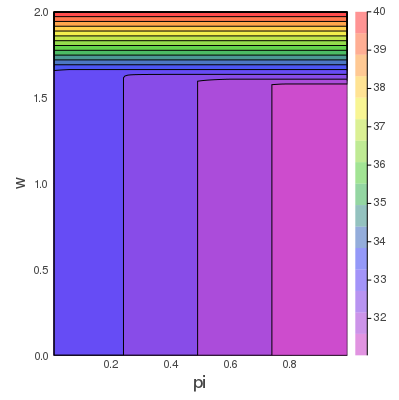

In [4]:
# Set up the problem and initial guess, solve by VFI
sp = SearchProblem(;w_grid_size=100, π_grid_size=100)
v_init = fill(sp.c / (1 - sp.β), sp.n_w, sp.n_π)
f(x) = T(sp, x)
v = compute_fixed_point(f, v_init)
policy = get_greedy(sp, v)

# Make functions for the linear interpolants of these
vf = extrapolate(interpolate((sp.w_grid, sp.π_grid), v, Gridded(Linear())),
                Flat())
pf = extrapolate(interpolate((sp.w_grid, sp.π_grid), policy,
                Gridded(Linear())), Flat())

function plot_value_function(;w_plot_grid_size = 100,
                            π_plot_grid_size = 100)
  π_plot_grid = range(0.001,  0.99, length =  π_plot_grid_size)
  w_plot_grid = range(0,  sp.w_max, length = w_plot_grid_size)
  Z = [vf(w_plot_grid[j], π_plot_grid[i])
          for j in 1:w_plot_grid_size, i in 1:π_plot_grid_size]
  p = contour(π_plot_grid, w_plot_grid, Z, levels=15, alpha=0.6,
              fill=true, size=(400, 400), c=:lightrainbow)
  plot!(xlabel="pi", ylabel="w", xguidefont=font(12))
  return p
end

plot_value_function()


<a id='odu-pol-vfi'></a>
The optimal policy:

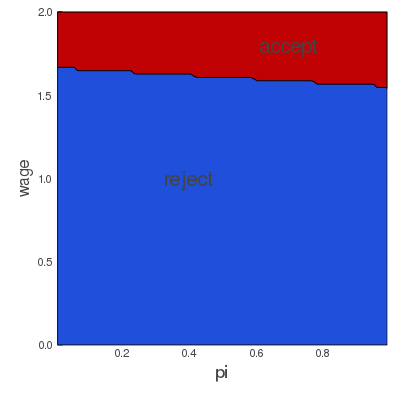

In [5]:
function plot_policy_function(;w_plot_grid_size = 100,
                              π_plot_grid_size = 100)
    π_plot_grid = range(0.001,  0.99, length = π_plot_grid_size)
    w_plot_grid = range(0,  sp.w_max, length = w_plot_grid_size)
    Z = [pf(w_plot_grid[j], π_plot_grid[i])
            for j in 1:w_plot_grid_size, i in 1:π_plot_grid_size]
    p = contour(π_plot_grid, w_plot_grid, Z, levels=1, alpha=0.6, fill=true,
                size=(400, 400), c=:coolwarm)
    plot!(xlabel="pi", ylabel="wage", xguidefont=font(12), cbar=false)
    annotate!(0.4, 1.0, "reject")
    annotate!(0.7, 1.8, "accept")
    return p
end

plot_policy_function()

The code takes several minutes to run.

The results fit well with our intuition from section [looking forward](#looking-forward).

- The black line in the figure above corresponds to the function $ \bar w(\pi) $ introduced there.  
- It is decreasing as expected.  

## Take 2: A More Efficient Method

Our implementation of VFI can be optimized to some degree.

But instead of pursuing that, let’s consider another method to solve for the optimal policy.

We will use iteration with an operator that has the same contraction rate as the Bellman operator, but

- one dimensional rather than two dimensional  
- no maximization step  


As a consequence, the algorithm is orders of magnitude faster than VFI.

This section illustrates the point that when it comes to programming, a bit of
mathematical analysis goes a long way.

### Another Functional Equation

To begin, note that when $ w = \bar w(\pi) $, the worker is indifferent
between accepting and rejecting.

Hence the two choices on the right-hand side of [(3)](#equation-odu-mvf) have equal value:


<a id='equation-odu-mvf2'></a>
$$
\frac{\bar w(\pi)}{1 - \beta}
= c + \beta \int V(w', \pi') \, h_{\pi}(w') \, dw' \tag{4}
$$

Together, [(3)](#equation-odu-mvf) and [(4)](#equation-odu-mvf2) give


<a id='equation-odu-mvf3'></a>
$$
V(w, \pi) =
\max
\left\{
    \frac{w}{1 - \beta} ,\, \frac{\bar w(\pi)}{1 - \beta}
\right\} \tag{5}
$$

Combining [(4)](#equation-odu-mvf2) and [(5)](#equation-odu-mvf3), we obtain

$$
\frac{\bar w(\pi)}{1 - \beta}
= c + \beta \int \max \left\{
    \frac{w'}{1 - \beta} ,\, \frac{\bar w(\pi')}{1 - \beta}
\right\}
\, h_{\pi}(w') \, dw'
$$

Multiplying by $ 1 - \beta $, substituting in $ \pi' = q(w', \pi) $ and using $ \circ $ for composition of functions yields


<a id='equation-odu-mvf4'></a>
$$
\bar w(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \bar w \circ q(w', \pi) \right\} \, h_{\pi}(w') \, dw' \tag{6}
$$

Equation [(6)](#equation-odu-mvf4) can be understood as a functional equation, where $ \bar w $ is the unknown function.

- Let’s call it the *reservation wage functional equation* (RWFE).  
- The solution $ \bar w $ to the RWFE is the object that we wish to compute.  

### Solving the RWFE

To solve the RWFE, we will first show that its solution is the
fixed point of a [contraction mapping](https://en.wikipedia.org/wiki/Contraction_mapping).

To this end, let

- $ b[0,1] $ be the bounded real-valued functions on $ [0,1] $  
- $ \| \psi \| := \sup_{x \in [0,1]} | \psi(x) | $  


Consider the operator $ Q $ mapping $ \psi \in b[0,1] $ into $ Q\psi \in b[0,1] $ via


<a id='equation-odu-dq'></a>
$$
(Q \psi)(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \psi \circ q(w', \pi) \right\} \, h_{\pi}(w') \, dw' \tag{7}
$$

Comparing [(6)](#equation-odu-mvf4) and [(7)](#equation-odu-dq), we see that the set of fixed points of $ Q $ exactly coincides with the set of solutions to the RWFE.

- If $ Q \bar w = \bar w $ then $ \bar w $ solves [(6)](#equation-odu-mvf4) and vice versa.  


Moreover, for any $ \psi, \phi \in b[0,1] $, basic algebra and the
triangle inequality for integrals tells us that


<a id='equation-odu-nt'></a>
$$
|(Q \psi)(\pi) - (Q \phi)(\pi)|
\leq \beta \int
\left|
\max \left\{w', \psi \circ q(w', \pi) \right\} -
\max \left\{w', \phi \circ q(w', \pi) \right\}
\right|
\, h_{\pi}(w') \, dw' \tag{8}
$$

Working case by case, it is easy to check that for real numbers $ a, b, c $ we always have


<a id='equation-odu-nt2'></a>
$$
| \max\{a, b\} - \max\{a, c\}| \leq | b - c| \tag{9}
$$

Combining [(8)](#equation-odu-nt) and [(9)](#equation-odu-nt2) yields


<a id='equation-odu-nt3'></a>
$$
|(Q \psi)(\pi) - (Q \phi)(\pi)|
\leq \beta \int
\left| \psi \circ q(w', \pi) -  \phi \circ q(w', \pi) \right|
\, h_{\pi}(w') \, dw'
\leq \beta \| \psi - \phi \| \tag{10}
$$

Taking the supremum over $ \pi $ now gives us


<a id='equation-odu-rwc'></a>
$$
\|Q \psi - Q \phi\|
\leq \beta \| \psi - \phi \| \tag{11}
$$

In other words, $ Q $ is a contraction of modulus $ \beta $ on the
complete metric space $ (b[0,1], \| \cdot \|) $.

Hence

- A unique solution $ \bar w $ to the RWFE exists in $ b[0,1] $.  
- $ Q^k \psi \to \bar w $ uniformly as $ k \to \infty $, for any $ \psi \in b[0,1] $.  

#### Implementation

These ideas are implemented in the `.res_wage_operator()` method from `odu.jl` as shown above.

The method corresponds to action of the operator $ Q $.

The following exercise asks you to exploit these facts to compute an approximation to $ \bar w $.

## Exercises


<a id='odu-ex1'></a>

### Exercise 1

Use the default parameters and the `.res_wage_operator()` method to compute an optimal policy.

Your result should coincide closely with the figure for the optimal policy [shown above](#odu-pol-vfi).

Try experimenting with different parameters, and confirm that the change in
the optimal policy coincides with your intuition.

## Solutions

### Exercise 1

This code solves the “Offer Distribution Unknown” model by iterating on
a guess of the reservation wage function. You should find that the run
time is much shorter than that of the value function approach in
`examples/odu_vfi_plots.jl`.

Compute iterate 10 with error 0.007194437603255555
Compute iterate 20 with error 0.0004348703417873523
Converged in 26 steps


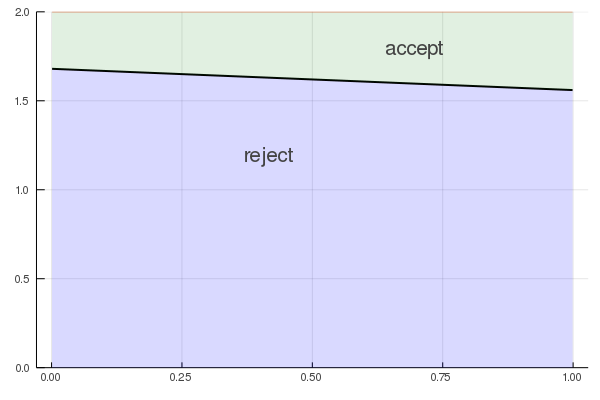

In [6]:
sp = SearchProblem(π_grid_size = 50)

ϕ_init = ones(sp.n_π)
f_ex1(x) = res_wage_operator(sp, x)
w̄ = compute_fixed_point(f_ex1, ϕ_init)

plot(sp.π_grid, w̄, linewidth = 2, color=:black,
     fillrange = 0, fillalpha = 0.15, fillcolor = :blue)
plot!(sp.π_grid, 2 * ones(length(w̄)), linewidth = 0, fillrange = w̄,
      fillalpha = 0.12, fillcolor = :green, legend = :none)
plot!(ylims = (0, 2), annotations = [(0.42, 1.2, "reject"),
                                     (0.7, 1.8, "accept")])

The next piece of code is not one of the exercises from QuantEcon – it’s
just a fun simulation to see what the effect of a change in the
underlying distribution on the unemployment rate is.

At a point in the simulation, the distribution becomes significantly
worse. It takes a while for agents to learn this, and in the meantime
they are too optimistic, and turn down too many jobs. As a result, the
unemployment rate spikes.

The code takes a few minutes to run.

Compute iterate 10 with error 0.007194437603255555
Compute iterate 20 with error 0.0004348703417873523
Converged in 26 steps


date = 20


date = 40


date = 60


date = 80


date = 100


date = 120
date = 140


date = 160


date = 180


date = 200


date = 220


date = 240


date = 260


date = 280


date = 300


date = 320


date = 340


date = 360


date = 380


date = 400


date = 420


date = 440


date = 460


date = 480


date = 500


date = 520


date = 540


date = 560


date = 580


date = 600


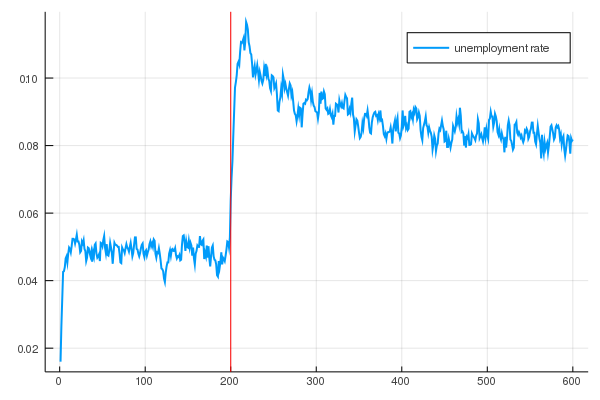

In [7]:
# Determinism and random objects.
using Random
Random.seed!(42)

# Set up model and compute the function w̄
sp = SearchProblem(π_grid_size = 50, F_a = 1, F_b = 1)
ϕ_init = ones(sp.n_π)
g(x) = res_wage_operator(sp, x)
w̄_vals = compute_fixed_point(g, ϕ_init)
w̄ = extrapolate(interpolate((sp.π_grid, ), w̄_vals,
                    Gridded(Linear())), Flat())

# Holds the employment state and beliefs of an individual agent.
mutable struct Agent{TF <: AbstractFloat, TI <: Integer}
    _π::TF
    employed::TI
end

Agent(_π=1e-3) = Agent(_π, 1)

function update!(ag, H)
    if ag.employed == 0
        w = rand(H) * 2   # account for scale in julia
        if w ≥ w̄(ag._π)
            ag.employed = 1
        else
            ag._π = 1.0 ./ (1 .+ ((1 - ag._π) .* sp.g(w)) ./ (ag._π * sp.f(w)))
        end
    end
    nothing
end

num_agents = 5000
separation_rate = 0.025  # Fraction of jobs that end in each period
separation_num = round(Int, num_agents * separation_rate)
agent_indices = collect(1:num_agents)
agents = [Agent() for i=1:num_agents]
sim_length = 600
H = sp.G                 # Start with distribution G
change_date = 200        # Change to F after this many periods
unempl_rate = zeros(sim_length)

for i in 1:sim_length
    if i % 20 == 0
        println("date = $i")
    end

    if i == change_date
        H = sp.F
    end

    # Randomly select separation_num agents and set employment status to 0
    shuffle!(agent_indices)
    separation_list = agent_indices[1:separation_num]

    for agent in agents[separation_list]
        agent.employed = 0
    end

    # update agents
    for agent in agents
        update!(agent, H)
    end
    employed = Int[agent.employed for agent in agents]
    unempl_rate[i] = 1.0 - mean(employed)
end

plot(unempl_rate, linewidth = 2, label = "unemployment rate")
vline!([change_date], color = :red, label = "")